# **Digital Signal and Image Management - 2D Signal Processing**<br/>

---

#Facial Expression Recognition

Authors:

Luca Galli - 905236 | Davide Ronchi - 903320

---



# Contents

The aim of this notebook is to process a video of a face, frame-by-frame, in order to obtain predictions on the emotions expressed.
To do that we pass each frame of the video to the models we want to test (we selected the Residual Network and the EfficientNet), we obtain the predictions, we plot the frame with the predicted emotion distribution and reconstruct the video.

# Importing Libraries

In [ ]:
# General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random
import pandas as pd
import scipy
import os, os.path
from io import StringIO
import re
import seaborn as sns
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


# File handling
import tarfile
import pickle

# Image Processing
from PIL import Image
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define base path

In [ ]:
base_path = "/content/drive/MyDrive/DSaIM_project/2D/Data/"

To demonstrate model functioning we use it on some videos of ourselves recording our faces while changing expressions, trying to simulate the emotions of interest.

In [ ]:
label_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown']

In [ ]:
def load_image(image_path):
  img = cv2.imread(base_path + image_path) #import example image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

Preprocess image functions

In [ ]:
def preprocess_image(img):
  img = cv2.resize(img, (48, 48))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = np.expand_dims(img, axis=0)
  img = np.expand_dims(img, axis=-1)
  img = img/255.0
  return img

In [ ]:
def preprocess_image_EN(img):
  img = cv2.resize(img, (48, 48))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = np.expand_dims(img, axis=0)
  img = np.expand_dims(img, axis=-1)
  return img

# Residual Network

Loading Model

In [ ]:
# Residual Network
res_model_probability_filepath = base_path + 'Models/res_model_probability_checkpoint.keras'
res_model_probability = keras.models.load_model(res_model_probability_filepath)

## Video1

We load the input video

In [ ]:
input_video_path = base_path + 'Images/input_videos/LucaEmotions2.mp4'

Separate each frame of the video into images

In [ ]:
cap = cv2.VideoCapture(input_video_path)

# Initialize an empty list to store the frames
frames = []

# Loop through the frames of the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to a NumPy array
    frame_array = np.array(frame)

    # Append the frame to the list
    frames.append(frame_array)

# Release the video capture object
cap.release()

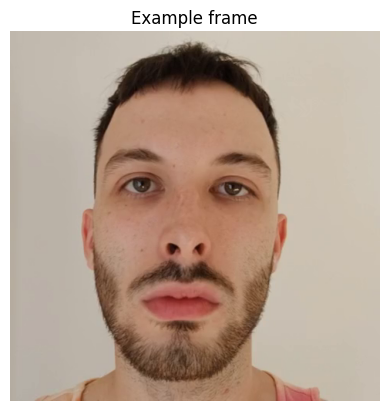

In [ ]:
plt.imshow(cv2.cvtColor(frames[3], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Example frame')
plt.show()

In [ ]:
predicted_frames = []
for frame in frames:
    processed_frame = preprocess_image(frame)
    predictions = res_model_probability.predict(processed_frame, verbose=False)

    sorted_indices = np.argsort(predictions[0])[::-1]
    sorted_predictions = predictions[0][sorted_indices]
    sorted_label_names = np.array(label_names)[sorted_indices]

    # Create figure
    fig = plt.Figure(figsize=(10, 4))
    canvas = FigureCanvas(fig)
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    # Plot image
    ax0 = fig.add_subplot(gs[0])
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ax0.imshow(gray_frame, cmap='gray')
    ax0.axis('off')

    # Plot text
    ax1 = fig.add_subplot(gs[1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    space = 0
    for i, s in enumerate(sorted_label_names):
        if sorted_predictions[i] > 0.10:
            ax1.text(0.1, 0.95 - 0.1 * space, f"{sorted_predictions[i] * 100:.0f}%  {s}", fontsize=12, va='top')
            space += 1

    # Add the figure to the list
    predicted_frames.append(fig)

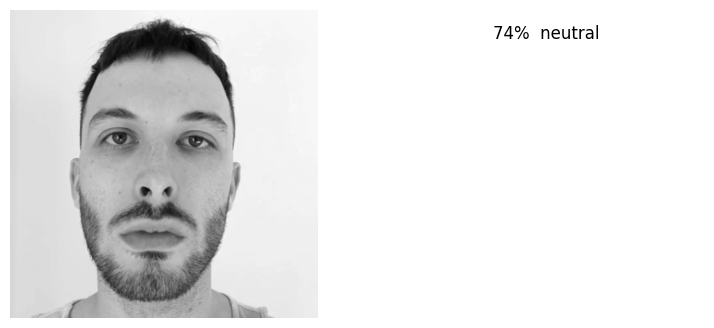

In [ ]:
predicted_frames[3]

Set paths for images

In [ ]:
image_folder = base_path + 'Images/demo_images_Resnet_Luca/'

Save figures in the drive folder as .png

In [ ]:
for i, fig in enumerate(predicted_frames):
    fig_path = os.path.join(image_folder, f'frame_{i:04d}.png')
    fig.savefig(fig_path, bbox_inches='tight')

set paths for the output video

In [ ]:
output_video_path = base_path + 'Images/output_videos/demo_video_resnet_luca.mp4'

Convert the images to video and save it to the drive folder

In [ ]:
# Get a list of image files and sort them numerically
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: int(x.split('_')[1].split('.')[0]))

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))

for image in images:
    img_path = os.path.join(image_folder, image)
    # print(f"Adding image: {img_path}")
    try:
      img = cv2.imread(img_path)
    except:
      print(f"Failed to read image: {img_path}")
      continue
    video.write(img)

cv2.destroyAllWindows()
video.release()


## Video2

We load the input video

In [ ]:
input_video_path = base_path + 'Images/input_videos/Davide2.mp4'

Separate each frame of the video into images

In [ ]:
cap = cv2.VideoCapture(input_video_path)

# Initialize an empty list to store the frames
frames = []

# Loop through the frames of the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to a NumPy array
    frame_array = np.array(frame)

    # Append the frame to the list
    frames.append(frame_array)

# Release the video capture object
cap.release()

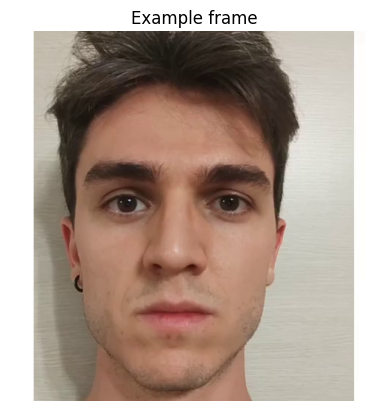

In [ ]:
plt.imshow(cv2.cvtColor(frames[3], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Example frame')
plt.show()

In [ ]:
predicted_frames = []
for frame in frames:
    processed_frame = preprocess_image(frame)
    predictions = res_model_probability.predict(processed_frame, verbose=False)

    sorted_indices = np.argsort(predictions[0])[::-1]
    sorted_predictions = predictions[0][sorted_indices]
    sorted_label_names = np.array(label_names)[sorted_indices]

    # Create figure
    fig = plt.Figure(figsize=(10, 4))
    canvas = FigureCanvas(fig)
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    # Plot image
    ax0 = fig.add_subplot(gs[0])
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ax0.imshow(gray_frame, cmap='gray')
    ax0.axis('off')

    # Plot text
    ax1 = fig.add_subplot(gs[1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    space = 0
    for i, s in enumerate(sorted_label_names):
        if sorted_predictions[i] > 0.10:
            ax1.text(0.1, 0.95 - 0.1 * space, f"{sorted_predictions[i] * 100:.0f}%  {s}", fontsize=12, va='top')
            space += 1

    # Add the figure to the list
    predicted_frames.append(fig)

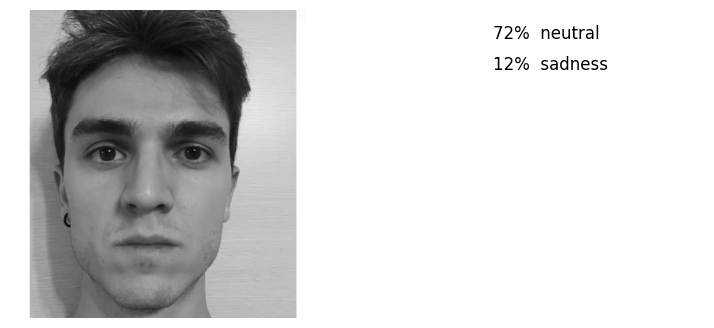

In [ ]:
predicted_frames[3]

Set paths for images

In [ ]:
image_folder = base_path + 'Images/demo_images_Resnet_Davide/'

Save figures in the drive folder as .png

In [ ]:
for i, fig in enumerate(predicted_frames):
    fig_path = os.path.join(image_folder, f'frame_{i:04d}.png')
    fig.savefig(fig_path, bbox_inches='tight')

set paths for the output video

In [ ]:
output_video_path = base_path + 'Images/output_videos/demo_video_resnet_davide.mp4'

Convert the images to video and save it to the drive folder

In [ ]:
# Get a list of image files and sort them numerically
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: int(x.split('_')[1].split('.')[0]))

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))

for image in images:
    img_path = os.path.join(image_folder, image)
    # print(f"Adding image: {img_path}")
    try:
      img = cv2.imread(img_path)
    except:
      print(f"Failed to read image: {img_path}")
      continue
    video.write(img)

cv2.destroyAllWindows()
video.release()


# EfficientNet

Loading Model

In [ ]:
EfficientNet_model_probability_ft_checkpoint_filepath = base_path + 'Models/EfficientNet_model_probability_ft_checkpoint.keras'
EfficientNet_model_probability_ft = keras.models.load_model(EfficientNet_model_probability_ft_checkpoint_filepath)

## Video1

We load the input video

In [ ]:
input_video_path = base_path + 'Images/input_videos/LucaEmotions2.mp4'

Separate each frame of the video into images

In [ ]:
cap = cv2.VideoCapture(input_video_path)

# Initialize an empty list to store the frames
frames = []

# Loop through the frames of the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to a NumPy array
    frame_array = np.array(frame)

    # Append the frame to the list
    frames.append(frame_array)

# Release the video capture object
cap.release()

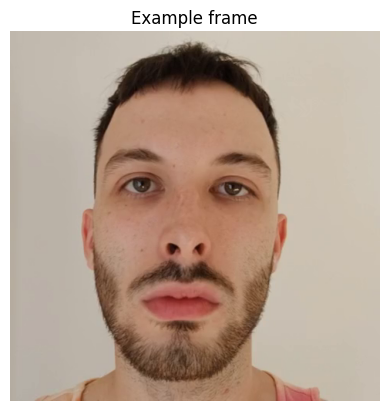

In [ ]:
plt.imshow(cv2.cvtColor(frames[3], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Example frame')
plt.show()

In [ ]:
predicted_frames = []
for frame in frames:
    processed_frame = preprocess_image_EN(frame)
    predictions = EfficientNet_model_probability_ft.predict(processed_frame, verbose=False)

    sorted_indices = np.argsort(predictions[0])[::-1]
    sorted_predictions = predictions[0][sorted_indices]
    sorted_label_names = np.array(label_names)[sorted_indices]

    # Create figure
    fig = plt.Figure(figsize=(10, 4))
    canvas = FigureCanvas(fig)
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    # Plot image
    ax0 = fig.add_subplot(gs[0])
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ax0.imshow(gray_frame, cmap='gray')
    ax0.axis('off')

    # Plot text
    ax1 = fig.add_subplot(gs[1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    space = 0
    for i, s in enumerate(sorted_label_names):
        if sorted_predictions[i] > 0.10:
            ax1.text(0.1, 0.95 - 0.1 * space, f"{sorted_predictions[i] * 100:.0f}%  {s}", fontsize=12, va='top')
            space += 1

    # Add the figure to the list
    predicted_frames.append(fig)

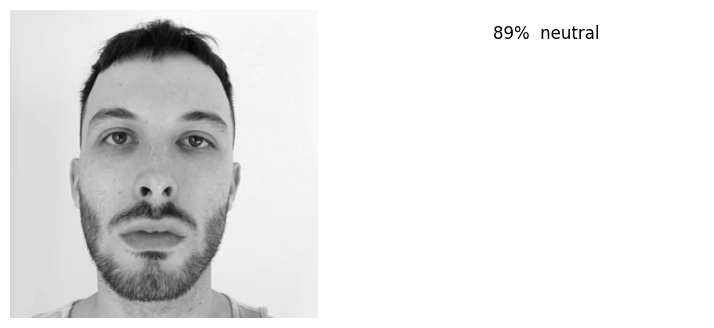

In [ ]:
predicted_frames[3]

Set paths for images

In [ ]:
image_folder = base_path + 'Images/demo_images_EfficientNet_Luca/'

Save figures in the drive folder as .png

In [ ]:
for i, fig in enumerate(predicted_frames):
    fig_path = os.path.join(image_folder, f'frame_{i:04d}.png')
    fig.savefig(fig_path, bbox_inches='tight')

set paths for the output video

In [ ]:
output_video_path = base_path + 'Images/output_videos/demo_video_efficientnet_luca.mp4'

Convert the images to video and save it to the drive folder

In [ ]:
# Get a list of image files and sort them numerically
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: int(x.split('_')[1].split('.')[0]))

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))

for image in images:
    img_path = os.path.join(image_folder, image)
    # print(f"Adding image: {img_path}")
    try:
      img = cv2.imread(img_path)
    except:
      print(f"Failed to read image: {img_path}")
      continue
    video.write(img)

cv2.destroyAllWindows()
video.release()


## Video2

We load the input video

In [ ]:
input_video_path = base_path + 'Images/input_videos/Davide2.mp4'

Separate each frame of the video into images

In [ ]:
cap = cv2.VideoCapture(input_video_path)

# Initialize an empty list to store the frames
frames = []

# Loop through the frames of the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to a NumPy array
    frame_array = np.array(frame)

    # Append the frame to the list
    frames.append(frame_array)

# Release the video capture object
cap.release()

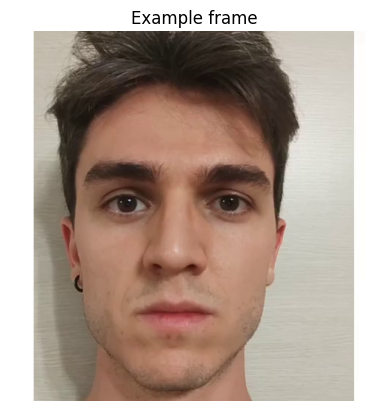

In [ ]:
plt.imshow(cv2.cvtColor(frames[3], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Example frame')
plt.show()

In [ ]:
predicted_frames = []
for frame in frames:
    processed_frame = preprocess_image_EN(frame)
    predictions = EfficientNet_model_probability_ft.predict(processed_frame, verbose=False)

    sorted_indices = np.argsort(predictions[0])[::-1]
    sorted_predictions = predictions[0][sorted_indices]
    sorted_label_names = np.array(label_names)[sorted_indices]

    # Create figure
    fig = plt.Figure(figsize=(10, 4))
    canvas = FigureCanvas(fig)
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    # Plot image
    ax0 = fig.add_subplot(gs[0])
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ax0.imshow(gray_frame, cmap='gray')
    ax0.axis('off')

    # Plot text
    ax1 = fig.add_subplot(gs[1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    space = 0
    for i, s in enumerate(sorted_label_names):
        if sorted_predictions[i] > 0.10:
            ax1.text(0.1, 0.95 - 0.1 * space, f"{sorted_predictions[i] * 100:.0f}%  {s}", fontsize=12, va='top')
            space += 1

    # Add the figure to the list
    predicted_frames.append(fig)

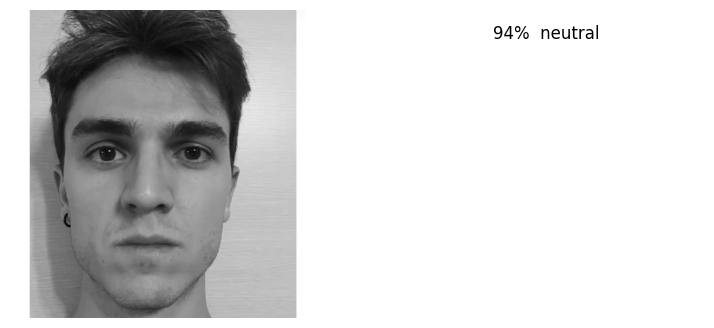

In [ ]:
predicted_frames[3]

Set paths for images

In [ ]:
image_folder = base_path + 'Images/demo_images_EfficientNet_Davide/'

Save figures in the drive folder as .png

In [ ]:
for i, fig in enumerate(predicted_frames):
    fig_path = os.path.join(image_folder, f'frame_{i:04d}.png')
    fig.savefig(fig_path, bbox_inches='tight')

set paths for the output video

In [ ]:
output_video_path = base_path + 'Images/output_videos/demo_video_efficientnet_davide.mp4'

Convert the images to video and save it to the drive folder

In [ ]:
# Get a list of image files and sort them numerically
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: int(x.split('_')[1].split('.')[0]))

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))

for image in images:
    img_path = os.path.join(image_folder, image)
    # print(f"Adding image: {img_path}")
    try:
      img = cv2.imread(img_path)
    except:
      print(f"Failed to read image: {img_path}")
      continue
    video.write(img)

cv2.destroyAllWindows()
video.release()